In [1]:
import sys
sys.path.append("..")
from models import base_model, training_utils, prediction_utils, exp_utils
import torch
import torch_geometric
from torch_geometric.nn import SAGEConv, GATConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import yaml
configs_folder = "/biodata/nyanovsky/datasets/dti/best_models/"
with open(configs_folder+"sage_config.yaml","r") as file:
    sage_config = yaml.safe_load(file)
with open(configs_folder+"gat_config.yaml","r") as file:
    gat_config = yaml.safe_load(file)

In [3]:
train_params_sage, gral_params_sage, conv_params_sage = sage_config["train"], sage_config["gral"], sage_config["conv"]
train_params_gat, gral_params_gat, conv_params_gat = gat_config["train"], gat_config["gral"], gat_config["conv"]

In [4]:
keys = [["weight_decay","lr","epochs","patience","delta","feature_dim","features"],
              ["pre_process_layers","post_process_layers", "layer_connectivity", "hidden_channels",
               "batch_norm", "dropout","macro_aggregation","L2_norm","msg_passing_layers","normalize_output"]
              ]
sage_keys = keys + ["aggr"]
gat_keys = keys + ["heads","concat","add_self_loops"]

In [5]:
data_folder = "/biodata/nyanovsky/datasets/dti/processed/v2/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

node_df = pd.read_csv(data_folder+"dti_tensor_df.csv",index_col=0)
#load data
datasets, node_map = training_utils.load_data(data_folder,load_inverted_map=False,load_test=True)

train_set, val_set, test_set = datasets

gene_feature_dict = training_utils.load_feature_dict(data_folder+"prot_features_64.txt", data_folder+"prot_features_ids.txt", 
                                                    node_df, "gene")

In [6]:
train_sage, val_sage, test_sage = exp_utils.init_features(train_set,val_set,test_set, train_params_sage, gene_feature_dict)
#train_gat, val_gat, test_gat = exp_utils.init_features(train_set,val_set,test_set, train_params_gat, gene_feature_dict)

/usr/users/nyanovsky/tesis/exploration/../models/training_utils.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_object[nodetype].x[tensor_idxs] = nodetype_embs


In [7]:
sage_model = base_model.base_model(SAGEConv,gral_params_sage, conv_params_sage, train_set.metadata(),[("gene","chg","chem")])
#gat_model = base_model.base_model(GATConv,gral_params_gat, conv_params_gat, train_set.metadata(),[("gene","chg","chem")])

In [8]:
full_set = torch.load(data_folder+"dti_full_dataset.pt")
negative_sampler = training_utils.NegativeSampler(full_set,("gene","chg","chem"),full_set["gene"]["degree_chg"],full_set["chem"]["degree_chg"])

In [9]:
sage_model, sage_results, sage_preds = exp_utils.run_experiment(sage_model, train_sage, val_sage, test_sage, train_params_sage, negative_sampler, node_df)[:-1]
#gat_model, gat_results, gat_preds = exp_utils.run_experiment(gat_model, train_gat, val_gat, test_gat, train_params_gat, negative_sampler, node_df)[:-1]

In [10]:
import seaborn as sns

In [24]:
gene_node_df = node_df[node_df["node_type"]=="gene"]
chem_node_df = node_df[node_df["node_type"]=="chem"]

def get_chg_deg(nodetype_df, tensor_idx):
    return nodetype_df[nodetype_df["tensor_index"]==tensor_idx]["ChG_deg"].values[0]

sage_preds["total_ChG_deg"] = sage_preds.apply(lambda row: get_chg_deg(gene_node_df, row["torch_gene_index"])+get_chg_deg(chem_node_df, row["torch_chem_index"]),axis=1)
#gat_preds["total_ChG_deg"] = gat_preds.apply(lambda row: get_chg_deg(gene_node_df, row["torch_gene_index"])+get_chg_deg(chem_node_df, row["torch_chem_index"]),axis=1)


In [12]:
def plot_scores_by_deg(preds):

    preds_t = preds[preds["label"]==1].copy()
    preds_f = preds[preds["label"]==0].copy()

    preds_t.sort_values(by="total_ChG_deg", inplace=True)
    preds_f.sort_values(by="total_ChG_deg", inplace=True)

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,5))

    axes[0].plot(preds_t["total_ChG_deg"][:-265], preds_t["score"][:-265], ".", alpha=0.4)
    
    axes[0].set_ylabel("score")
    axes[0].set_title("aristas positivas")

    axes[1].plot(preds_f["total_ChG_deg"][:-80], preds_f["score"][:-80], ".", alpha=0.4)
    axes[1].set_title("aristas negativas")

    fig.text(s="Grado combinado en la capa DTI",x=0.42, y=-0.02, fontsize=10)
    plt.tight_layout()
    plt.show()

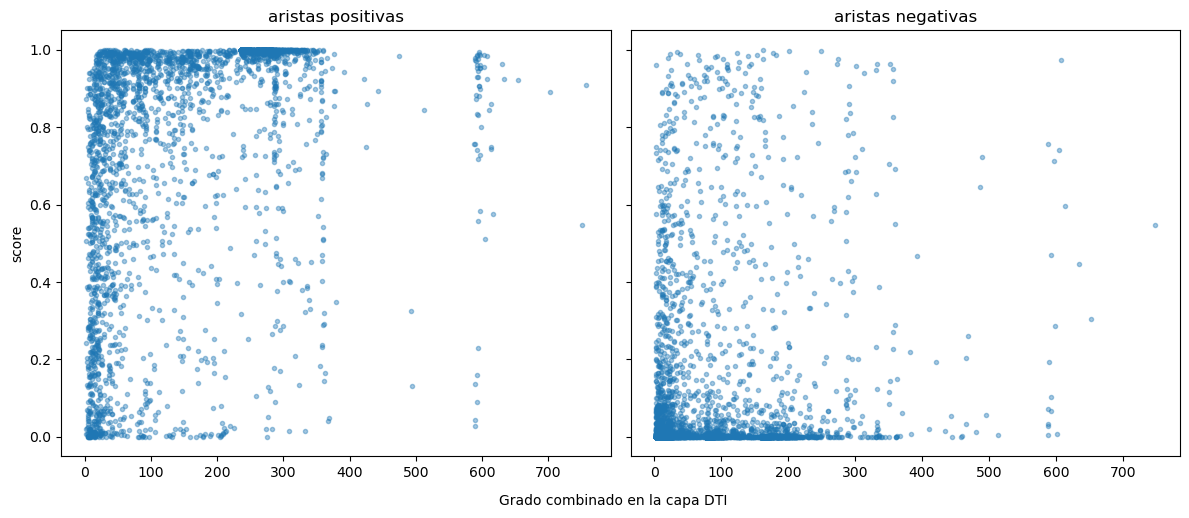

In [13]:
plot_scores_by_deg(sage_preds)

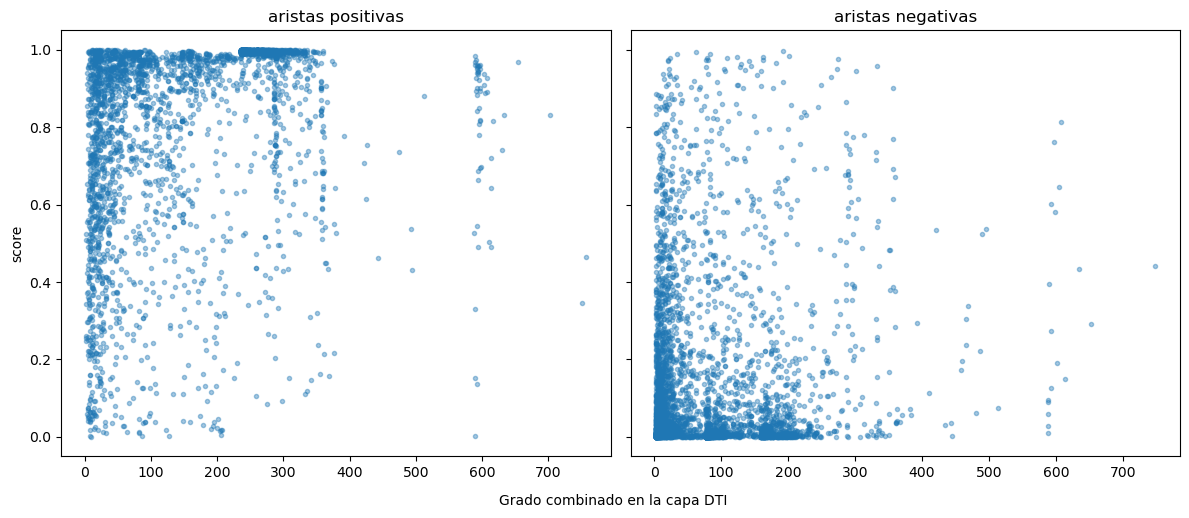

In [15]:
#plot_scores_by_deg(gat_preds)

In [14]:
import networkx as nx 
import pickle 
import pickle
G = pickle.load(open(data_folder+"dti_graph.pickle",'rb'))
def get_rel_subgraph(G: nx.Graph, rel: str) -> nx.Graph:
    rel_edges = [(u,v) for (u,v,r_dict) in G.edges.data() if r_dict["edge_type"]==rel]
    rel_subgraph = G.edge_subgraph(rel_edges).copy()
    return rel_subgraph
ChG_subgraph = get_rel_subgraph(G, "chg")
ChCh_subgraph = get_rel_subgraph(G, "chch")
GG_subgraph = get_rel_subgraph(G, "gg")

In [15]:
gene_node_df.set_index("tensor_index",inplace=True)
chem_node_df.set_index("tensor_index",inplace=True)

In [16]:
gene_test_nodes = gene_node_df.loc[sage_preds["torch_gene_index"].unique()]["node_id"]
chem_test_nodes = chem_node_df.loc[sage_preds["torch_chem_index"].unique()]["node_id"]
test_nodes = np.concatenate((gene_test_nodes, chem_test_nodes))

In [17]:
def prec_at_k(df, col, k):
    prec_per_node = {}
    for node, group in df.groupby(col):
        max_k = group["label"].sum()
        actual_k = min(k, int(max_k))

        if actual_k > 0:
            group_sorted = group.sort_values(by='score', ascending=False)

            
            
            top_k = group_sorted.head(actual_k)
            
            num_true_in_top_k = top_k['label'].sum() 
            total_true_edges = group['label'].sum()  
    
        
            prec = num_true_in_top_k/len(top_k)
            prec_per_node[node] = prec

        else:
            continue
    
    return prec_per_node


In [18]:
from exploration.explor_utils import get_edgetype_adjdict

In [19]:
gene_to_drug_adjdict = get_edgetype_adjdict(("gene","chg","chem"), full_set)
drug_to_gene_adjdict = get_edgetype_adjdict(("chem","chg","gene"), full_set)

In [20]:
val_sup_set = val_set.edge_label_index_dict["gene","chg","chem"]
val_sup_labels = val_set.edge_label_dict["gene","chg","chem"]
first_neg = torch.nonzero(val_sup_labels==0)[0].item()
val_neg_set = val_sup_set[:, first_neg:]

In [21]:
encodings_dict = training_utils.get_encodings(sage_model, test_sage)

In [22]:
def balance_negs(df, src, trgt, src_adjdict):
    src_col, trgt_col = f"torch_{src}_index", f"torch_{trgt}_index"
    num_nodes_trgt = full_set[trgt].num_nodes
    neg_df = pd.DataFrame(columns=[src_col, trgt_col, "score","label"])

    if src=="gene":
        j=0
    else:
        j=1
    for node, group in df.groupby(src_col):
        pos_surplus = 2*group["label"].sum()-group.shape[0]
        if pos_surplus>0: 
            test_negatives = group[trgt_col]
            val_negatives = val_neg_set[j,val_neg_set[1-j]==node]
            trgt_negs = []
            while len(trgt_negs) < pos_surplus:
                trgt_neg = np.random.randint(num_nodes_trgt)
                if (trgt_neg not in src_adjdict[node]) and (trgt_neg not in test_negatives) and (trgt_neg not in val_negatives):
                    trgt_negs.append(trgt_neg)

            scores = torch.sigmoid((encodings_dict[src][node]*encodings_dict[trgt][torch.tensor(trgt_negs)]).sum(axis=1))
            node_neg_df = pd.DataFrame({src_col:node, trgt_col:trgt_negs, "score":scores, "label":0})
            neg_df = pd.concat([neg_df, node_neg_df])
    return neg_df

In [25]:
balanced_gene_negs = balance_negs(sage_preds, "gene","chem", gene_to_drug_adjdict)
balanced_gene_preds = pd.concat([sage_preds[["torch_gene_index","torch_chem_index","score","label"]], balanced_gene_negs])
balanced_drug_negs = balance_negs(balanced_gene_preds, "chem", "gene", drug_to_gene_adjdict)

balanced_preds = pd.concat([balanced_gene_preds, balanced_drug_negs])
balanced_preds["total_ChG_deg"] = balanced_preds.apply(lambda row: get_chg_deg(gene_node_df, row["torch_gene_index"])+get_chg_deg(chem_node_df, row["torch_chem_index"]),axis=1)

/tmp/ipykernel_2282141/1596392392.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  neg_df = pd.concat([neg_df, node_neg_df])
/tmp/ipykernel_2282141/1596392392.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  neg_df = pd.concat([neg_df, node_neg_df])


In [186]:
ks = [1,2,3,4,5,6,7,8,9,10,15,20,25, 40]
mean_precs_at_k = []
for k in ks:
    prec_at_k_gene = prec_at_k(balanced_preds,"torch_gene_index", k=k)
    prec_at_k_chem = prec_at_k(balanced_preds,"torch_chem_index", k=k)

    mean_prec_at_k = np.mean(list(prec_at_k_gene.values())+list(prec_at_k_chem.values()))

    mean_precs_at_k.append(mean_prec_at_k)

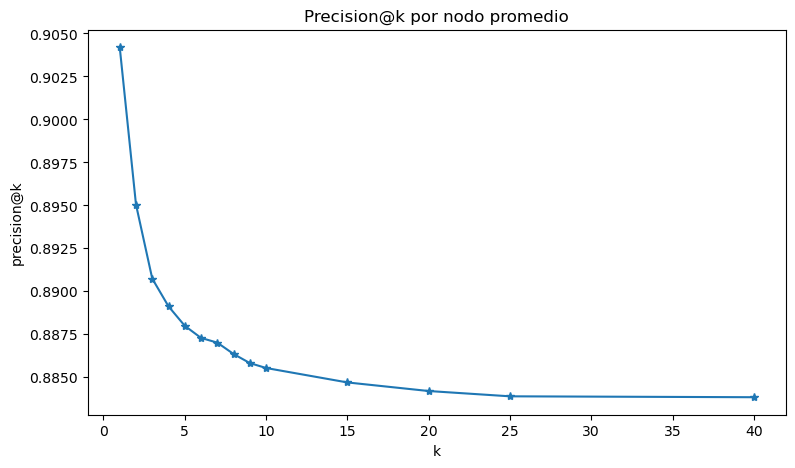

In [188]:
plt.figure(figsize=(9,5))
plt.plot(ks, mean_precs_at_k,"*-")

plt.xlabel("k")
plt.ylabel("precision@k")
plt.title("Precision@k por nodo promedio")
plt.show()

In [26]:
prec_at_5_gene = prec_at_k(balanced_preds, "torch_gene_index", 5)
prec_at_5_chem = prec_at_k(balanced_preds, "torch_chem_index", 5)


In [27]:
gene_node_df_ = gene_node_df.set_index("tensor_index", drop=False)
chem_node_df_ = chem_node_df.set_index("tensor_index", drop=False)


In [28]:
gene_prec_at_5 = [(gene,prec,gene_node_df_.loc[gene,"ChG_deg"]) for gene, prec in prec_at_5_gene.items()]
chem_prec_at_5 = [(chem,prec,chem_node_df_.loc[chem,"ChG_deg"]) for chem, prec in prec_at_5_chem.items()]


In [29]:
metrics_gene_df = pd.DataFrame(gene_prec_at_5, columns=["gene_tensor_index","prec_at_5", "ChG_deg"])
metrics_chem_df = pd.DataFrame(chem_prec_at_5, columns=["chem_tensor_index","prec_at_5", "ChG_deg"])

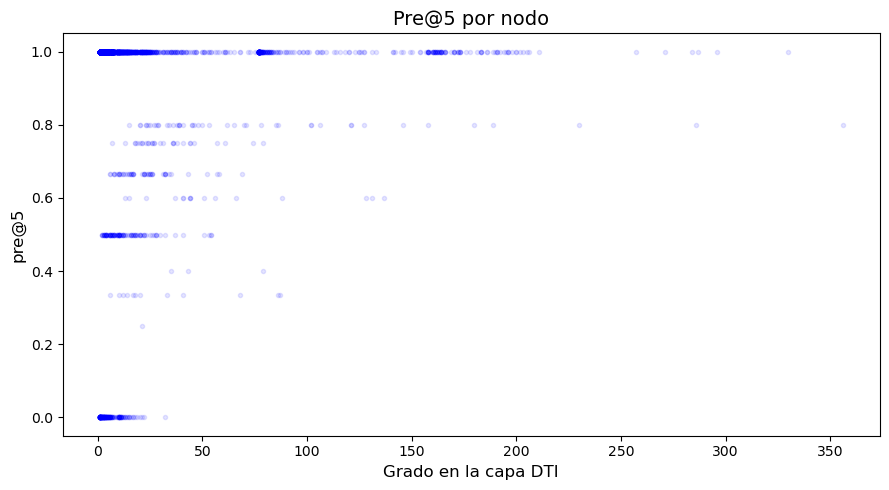

In [30]:
metrics_df = pd.concat((metrics_gene_df[["ChG_deg", "prec_at_5"]], metrics_chem_df[["ChG_deg", "prec_at_5"]])).sort_values(by="ChG_deg")
plt.figure(figsize=(9,5))

plt.plot(metrics_df["ChG_deg"][:-2], metrics_df["prec_at_5"][:-2], "b.", alpha=0.1)
plt.ylabel("pre@5", fontsize=12)

plt.xlabel("Grado en la capa DTI", fontsize=12)
plt.title("Pre@5 por nodo", fontsize=14)
plt.tight_layout()
plt.show()